# Voortoets interventions

Voortoets is a website of the Flanders Goverment to prescan requests for permits for actions involving groundwater.

A Voortoets case or project is called an intervention, which is the specification of an action with resepect to the groundwater system, extraction etc., that may affect a vulnerable natural area.

A series of 45 interventions have been specified and modelled both regionally and locally using the Flamish "Grondwatersimulator". The folders and subfolders pertaining to these example interventions have been used to extract the grids and layer properties of the regional models, the layer properties and the interventions from the /input/userinput.json file of each case. The results are then used to compute the same interventions using a simple 15x15 km finite difference model generated using these data and using the Open Street Map to get the occurence of surface wate everywhere in Flanders.

Theo Olsthoorn 2025-11-02

In [17]:
import os
import sys
from pathlib import Path

sys.path.insert(0, str(Path(os.getcwd()).parent))

import numpy as np
import shapely
import etc

from flopy.mf6.utils import MfGrdFile
from src import vtl_interventions as inv

# --- Project folder
try:
    prj_folder = os.path.join(os.getcwd(), '../data', '6194_GWS_testen')
    assert os.path.isdir(prj_folder), f"Path not found <{prj_folder}>"
except Exception as e:
    prj_folder = os.path.join(os.getcwd(), 'data', '6194_GWS_testen')
    assert os.path.isdir(prj_folder), f"Path not found <{prj_folder}>"

# GeoDataFrame of all interventions

A GeoDataFrame of all interventions is generated from the userinput.json in each folder.

This works, but is now obsolete. Working with a dictionary is much more precise and convenient (see further down)

In [8]:
# --- is now obsolete

interventions_gdf = inv.userinput_fr_json(prj_folder)
print(interventions_gdf.head())

print(f"Loaded {len(interventions_gdf)} features from {interventions_gdf['simulation_name'].nunique()} projects")

interventions_gdf

   id             name                         lowering unit  \
0   1   filterbemaling  [[0, 3.95], [183, 0], [365, 0]]    m   
1   3   bouwput_buffer                              NaN  NaN   
2   2  centrum_bouwput                              NaN  NaN   
3   3          bouwput     [[0, 1], [183, 0], [365, 0]]    m   
4   6    bouwputbuffer                              NaN  NaN   

           layer_type                                           geometry  \
0  dewatering_polygon  POLYGON ((61231 185559, 61246 185571, 61278 18...   
1    receptor_polygon  POLYGON ((61230 185569, 61250 185581, 61289 18...   
2      receptor_point                               POINT (61253 185547)   
3  dewatering_polygon  POLYGON ((104185 194661, 104168 194672, 104194...   
4    receptor_polygon  POLYGON ((104194 194719, 104217 194705, 104189...   

         simulation_name                         source_zip flow_rates  \
0  hh-212-filterbemaling  Rapport HH_212_filterbemaling.zip        NaN   
1  hh-212-

,id,name,lowering,unit,layer_type,geometry,simulation_name,source_zip,flow_rates,depth_filter,percentage,depth_aquifer
0,1,filterbemaling,"[[0, 3.95], [183, 0], [365, 0]]",m,dewatering_polygon,"POLYGON ((61231 185559, 61246 185571, 61278 18...",hh-212-filterbemaling,Rapport HH_212_filterbemaling.zip,NaN,NaN,NaN,NaN
1,3,bouwput_buffer,NaN,NaN,receptor_polygon,"POLYGON ((61230 185569, 61250 185581, 61289 18...",hh-212-filterbemaling,Rapport HH_212_filterbemaling.zip,NaN,NaN,NaN,NaN
2,2,centrum_bouwput,NaN,NaN,receptor_point,POINT (61253 185547),hh-212-filterbemaling,Rapport HH_212_filterbemaling.zip,NaN,NaN,NaN,NaN
3,3,bouwput,"[[0, 1], [183, 0], [365, 0]]",m,dewatering_polygon,"POLYGON ((104185 194661, 104168 194672, 104194...",gk-211-open-bemaling,Rapport GK_211_open_bemaling.zip,NaN,NaN,NaN,NaN
4,6,bouwputbuffer,NaN,NaN,receptor_polygon,"POLYGON ((104194 194719, 104217 194705, 104189...",gk-211-open-bemaling,Rapport GK_211_open_bemaling.zip,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
215,31,lijnbemaling_buffer,NaN,NaN,receptor_polygon,"POLYGON ((171939 172819, 172007 172808, 171979...",lc-221-lijnbemaling-filters,Rapport LC_221_lijnbemaling_filters.zip,NaN,NaN,NaN,NaN
216,30,lijnbemaling_centrum,NaN,NaN,receptor_point,POINT (171926 172548),lc-221-lijnbemaling-filters,Rapport LC_221_lijnbemaling_filters.zip,NaN,NaN,NaN,NaN
217,32,verharding,NaN,%,hardening_polygon,"POLYGON ((171861 172432, 171822 172524, 171915...",lc-4-verharding,Rapport LC_4_verharding.zip,NaN,NaN,"[[0, 100]]",NaN
218,34,verharding_buffer,NaN,NaN,receptor_polygon,"POLYGON ((171805 172532, 171917 172580, 171969...",lc-4-verharding,Rapport LC_4_verharding.zip,NaN,NaN,NaN,NaN


# Overview of all cases with their interventions

The more convenient way to get the interventions, as a dictionary:

1. All cases are read in from their userinput.json files (<case folder>/input/usrinput.json)
2. They are listed below together with their intervention types and number of interventions objects

In [30]:

# --- get user input for all cases from the project folder. The userinput is a json file
# --- which determines case and its interventions.
cases = inv.cases_fr_json(prj_folder=prj_folder)

# --- Show for each case which interventions is has:
print('\n# --- interventions ---\n')

for id in range(len(cases)):
    case = cases[id]
    
    s1 = f"case {id} {case['simulation_name']:35}: "

    interventions = case['interventions']
    s2 = []
    for k in interventions.keys():
        s2.append(f"{k}: N={len(interventions[k])}")
    print(s1 + ', '.join(s2))



# --- interventions ---

case 0 bp-11-seizoenale-winning           : extraction_irrigation_point: N=1
case 1 lc-212-filterbemaling              : dewatering_polygon: N=1
case 2 gk-212-filterbemaling              : dewatering_polygon: N=1
case 3 hh-12-permanente-winning           : extraction_general_point: N=1
case 4 hh-4-verharding                    : hardening_polygon: N=1
case 5 bm-216-retourbemaling-bronnen      : dewatering_polygon: N=1, recharge_point: N=14
case 6 bm-213-bronbemaling                : dewatering_polygon: N=1
case 7 gk-215-retourbemaling-bronnen      : dewatering_polygon: N=1, recharge_point: N=13
case 8 bm-11-seizoenale-winning           : extraction_irrigation_point: N=1
case 9 bp-4-verharding                    : hardening_polygon: N=1
case 10 hh-211-open-bemaling               : dewatering_polygon: N=1
case 11 gk-221-lijnbemaling-filters        : dewatering_line: N=5
case 12 lc-211-open-bemaling               : dewatering_polygon: N=1
case 13 hh-3-permanente-

# Location of each intervention

Use the cases from the previous cell.


# --- Reception points ---

case 0 bp-11-seizoenale-winning           : winningsput         , x=167728, y=225424
case 1 lc-212-filterbemaling              : centrum_bouwput     , x=171912, y=172553
case 2 gk-212-filterbemaling              : centrum_bouwput     , x=104190, y=194689
case 3 hh-12-permanente-winning           : winningsput_obs     , x= 61220, y=185566
case 4 hh-4-verharding                    : verharding_centrum  , x= 61291, y=185578
case 5 bm-216-retourbemaling-bronnen      : centrum_bouwput     , x=211110, y=193502
case 6 bm-213-bronbemaling                : centrum_bouwput     , x=211110, y=193502
case 7 gk-215-retourbemaling-bronnen      : centrum_bouwput     , x=104189, y=194689
case 8 bm-11-seizoenale-winning           : winningsput         , x=211110, y=193502
case 9 bp-4-verharding                    : verharding_centrum  , x=167699, y=225413
case 10 hh-211-open-bemaling               : centrum_bouwput     , x= 61254, y=185544
case 11 gk-221-lijnbemaling-filters

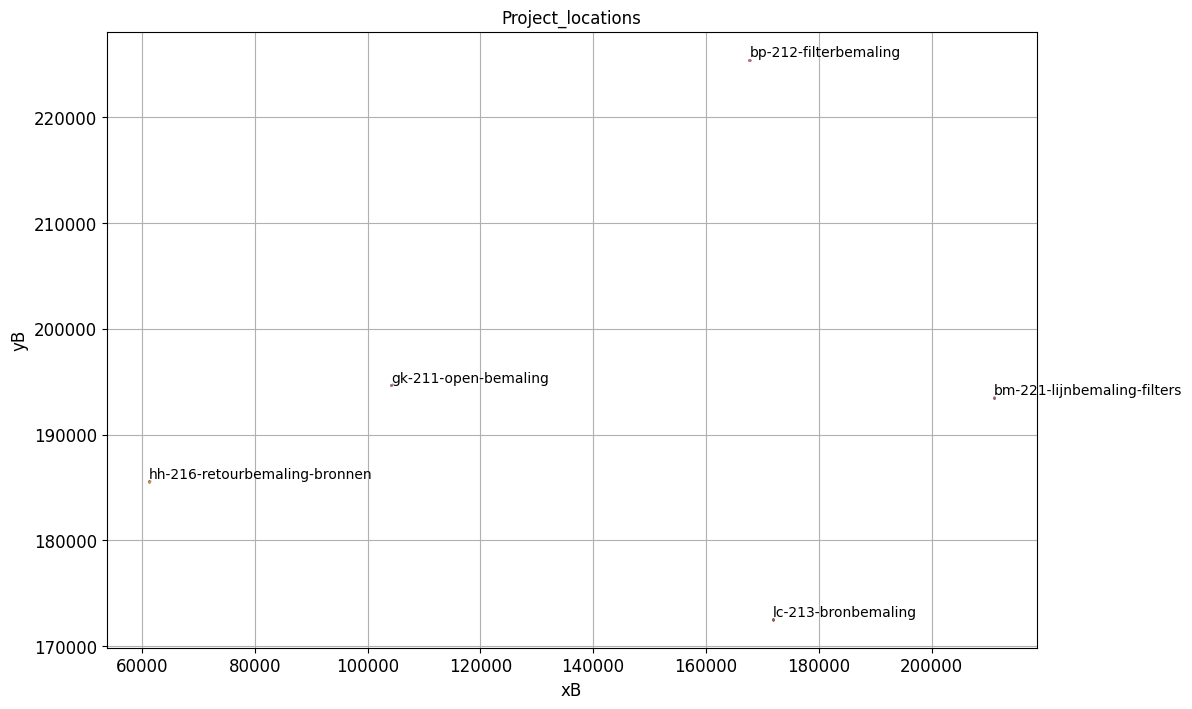

In [38]:

print("\n# --- Reception points ---\n")

proj_coords = []

for id in range(len(cases)):
    case = cases[id]
    
    s1 = f"case {id} {case['simulation_name']:35}: "
    
    rps = case['receptors']['receptor_point']
    s2 = []
    for rp in rps[:1]:
        x, y =  [rp['geometry'].x, rp['geometry'].y]                
        s2.append(f"{rp['name']:20}, x={x:6.0f}, y={y:6.0f}")
    
    # --- Append the last coordinates of this case
    proj_coords.append([x, y])

    print(s1 + ', '.join(s2))
    
proj_coords = np.array(proj_coords)
ax = etc.newfig("Project_locations", "xB", "yB")


grp = {}
X, Y = proj_coords.T
grp[0] = {'mask': X < 80000}
grp[1] = {'mask': np.logical_and(X > 100000, X < 140000)}
grp[2] = {'mask': Y > 220000}
grp[3] = {'mask': Y < 180000}
grp[4] = {'mask': X > 200000}

for i in grp.keys():
    Id = np.arange(len(cases))[grp[i]['mask']]
    for id in Id:
        ax.plot(X[id], Y[id], '.', ms=1)    
    ax.text(X[id], Y[id], cases[id]['simulation_name'], ha='left', va='bottom')

# There are in fact only 5 really different case locations


This shows that the projects are located relatively close to each other

In [45]:
Id_all = np.arange(len(proj_coords))
for i in range(5):
    Id = Id_all[grp[i]['mask']]
    print('Group {i}:')
    print(f"X = {X[Id]}")
    print(f"Y = {Y[Id]}")


Group {i}:
X = [61220. 61291. 61254. 61291. 61253. 61220. 61388. 61254. 61254.]
Y = [185566. 185578. 185544. 185578. 185547. 185566. 185586. 185546. 185546.]
Group {i}:
X = [104190. 104189. 104269. 104185. 104185. 104190. 104185. 104185. 104190.]
Y = [194689. 194689. 194756. 194689. 194692. 194689. 194692. 194689. 194689.]
Group {i}:
X = [167728. 167699. 167710. 167728. 167712. 167712. 167728. 167699. 167712.]
Y = [225424. 225413. 225432. 225424. 225433. 225433. 225422. 225413. 225432.]
Group {i}:
X = [171912. 171911. 171889. 171911. 171910. 171826. 171889. 171926. 171911.]
Y = [172553. 172553. 172498. 172554. 172553. 172502. 172498. 172548. 172555.]
Group {i}:
X = [211110.         211110.         211110.         211110.
 211111.         211111.         211110.         211110.
 211099.91877749]
Y = [193502.         193502.         193502.         193502.
 193505.         193505.         193502.         193502.
 193496.71014745]



# intervention object data

Each case has interventions defined by first the type of intervention objects, which
is followed by a list of actual intervention objects with individual properties.
As such, a building pit has "dewatering_polygon" as the type of its intervention objects.
(there is no case having more than one "dewatering_objects", but new case might have them).
Cases with lijnbemaling have "dewatering_line" as their intervention object type, which is
then followed by as list of actual "dewatering_line" objects. Each such object may have
its own lowering schedule in time and lowewring defined by its parameter "lowering" which is
a list of [time, lowering] pairs.
Likewise for wells (permanente winning, irrigatie, retourbemaling)
Cases specifying retourbemaling have two intervention types:

   1) dewatering_polygon (followed by a list of (1) dewatering polyogons)
   2) recharge_point (followed by a list of n recharge points) with flow_rates.

Projects defining hardening of a surface have "hardening_polygon" as their object type
followed by a list of (1) such objects, each of which has its geometry and its percentage of hardening over time (list of [time, perc] pairs).


Some grid properties
grid type DISV, cells per layer 23417, number of layers 7
Layering at postion 172824 173180 is top: 56.2216, bottom [53.878  48.049  39.8985  0.6306  0.6306  0.6306  0.6306]


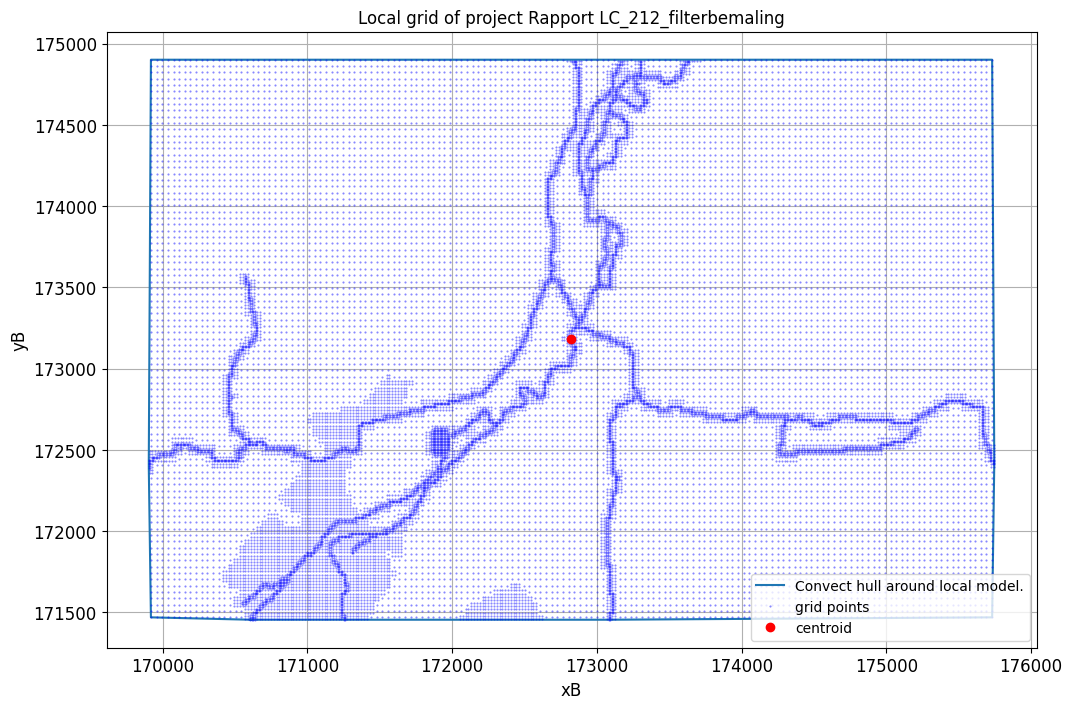

In [29]:
# --- get local grid info from the grb file of an arbitrry project

# --- Arbitrary project
prj_nm = 'Rapport LC_212_filterbemaling'

# --- the csv file of the vertices was extracted from the .disv file on the same directory
grb_file = os.path.join(prj_folder, prj_nm, 'model', 'no_permits.disv.grb')
assert os.path.isfile(grb_file), f"Can't open file <{grb_file}>"

# --- read the grid
grb = MfGrdFile(grb_file)

# --- Get some basic info
print("Some grid properties")
print(f"grid type {grb.grid_type}, cells per layer {grb.ncpl}, number of layers {grb.nlay}")

# --- Get cell coordinates and vertices
xy = grb.cellcenters
mp = shapely.MultiPoint(xy)
ch = shapely.convex_hull(mp)
ctr = shapely.centroid(ch)

ax = etc.newfig(f"Local grid of project {prj_nm}",  'xB', 'yB')

ax.plot(*np.array(ch.exterior.xy), label="Convect hull around local model.")
ax.plot(*xy.T, 'b.', ms=1, lw=0.25, alpha=0.5, label='grid points')
ax.plot(ctr.x, ctr.y, 'ro', label='centroid')
ax.legend()

# verts  = grb.verts           # list of (x, y) vertex coordinates
# iverts = grb.iverts          # cell-to-vertex connectivity

# --- top of the model
top = grb.top

# --- elevation of layer bottoms
botm = grb.bot.reshape(grb.nlay, grb.ncpl)

# --- get the center of the model (near the point of the project)
dxy = np.array([[ctr.x, ctr.y]]) - grb.verts
R = np.sqrt(dxy.T[0] + dxy.T[1])
i = np.argmin(R)
z = np.hstack((grb.top[i], botm[:, i]))

print(f"Layering at postion {ctr.x:.0f} {ctr.y:.0f} is top: {top[i]}, bottom {botm[:, i]}")
